In [1]:
!pip install pennylane
!pip install qiskit
!pip install qiskit_nature

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 13.2 MB/s eta 0:00:00


In [2]:
import json
import pennylane as qml
from pennylane import qchem 
import pennylane.numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.drivers import Molecule
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit import Aer
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.circuit.library import UCC

import warnings
warnings.filterwarnings('ignore')

<ipython-input-2-345fc2c37443>:12: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
<ipython-input-2-345fc2c37443>:12: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory


In [25]:
r=1.7
hydrogen_t = [["H", [-r, 0.0, 0.0]], 
              ["Be", [0.0, 0.0, 0.0]], 
              ["H", [r, 0.0, 0.0]]]
                  
h3p = Molecule(
    geometry=  hydrogen_t,
    multiplicity=1, 
    charge=0, 
)

driver = ElectronicStructureMoleculeDriver(h3p, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [26]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  3
number of beta electrons:  3
number of spin orbitals:  14
nuclear repulsion energy:  2.6458860546


In [27]:
PN_property = properties.get_property("ParticleNumber")

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=4, #how many electrons we have in our active space
    num_molecular_orbitals=6, #how many orbitals we have in our active space
)

# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [28]:
mapper = JordanWignerMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
print(qubit_op)

-1.0033275559633967 * IIIIIIIIIIII
- 0.22615663558196006 * IIIIIIIIIIIZ
+ 0.04964572261505297 * IIIIIIIYZZZY
+ 0.04964572261505297 * IIIIIIIXZZZX
- 0.23873641581200938 * IIIIIIIIIIZI
+ 0.07746836851665768 * IIIIIIYZZZYI
+ 0.07746836851665768 * IIIIIIXZZZXI
- 0.4339932746983885 * IIIIIIIIIZII
- 0.4339932746983885 * IIIIIIIIZIII
- 0.4049918116059218 * IIIIIIIZIIII
- 0.5805966748013958 * IIIIIIZIIIII
- 0.22615663558195984 * IIIIIZIIIIII
+ 0.04964572261505296 * IYZZZYIIIIII
+ 0.04964572261505296 * IXZZZXIIIIII
- 0.23873641581200922 * IIIIZIIIIIII
+ 0.0774683685166577 * YZZZYIIIIIII
+ 0.0774683685166577 * XZZZXIIIIIII
- 0.43399327469838844 * IIIZIIIIIIII
- 0.4339932746983884 * IIZIIIIIIIII
- 0.4049918116059218 * IZIIIIIIIIII
- 0.5805966748013959 * ZIIIIIIIIIII
+ 0.05434795432072216 * IIIIIIIIIIZZ
- 0.01005851166890772 * IIIIIIYZZZYZ
- 0.01005851166890772 * IIIIIIXZZZXZ
+ 0.07482343140406228 * IIIIIIIIIZIZ
+ 0.07482343140406228 * IIIIIIIIZIIZ
+ 0.06959111091151944 * IIIIIIIZIIIZ
+ 0.08216739

# Get the exact solution from qiskit.

In [29]:
vqe_factory = VQEUCCFactory( 
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(converter, vqe_factory)  # Define Numpy
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

Reference energy :  (-15.527759639229922+0j)


In [61]:
def hydrogen_hamiltonian(coordinates, charge, active_orb=6, num_e=4):
    """Calculates the qubit Hamiltonian of the hydrogen molecule.
    
    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.

    Returns:
        (qml.Hamiltonian): A PennyLane Hamiltonian.
    """
    return qml.qchem.molecular_hamiltonian(
        [ "H","Be", "H"], coordinates, charge, basis="sto-3g",active_electrons=num_e, active_orbitals=active_orb
    )[0]

def num_electrons(charge):
    """The total number of electrons in the hydrogen molecule.
    
    Args:
        charge (int): The electric charge given to the hydrogen molecule.

    Returns: 
        (int): The number of electrons.
    """
    return 4-charge

def hf(electrons, num_qubits):
    """Calculates the Hartree-Fock state of the hydrogen molecule.
    
    Args:
        electrons (int): The number of electrons in the hydrogen molecule.
        num_qubits (int): The number of qubits needed to represent the hydrogen molecule Hamiltonian.

    Returns:
        (numpy.tensor): The HF state.
    """
    # Put your solution here #
    return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

In [31]:
def BeH2_data(r,threshold, selection=True):
    a0=0.529177210903
    coordinates=[ 0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0] # in atomic unit
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge)

    electrons = num_electrons(charge)
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)
    # singles and doubles are used to make the AllSinglesDoubles template
    singles, doubles = qml.qchem.excitations(electrons, num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )

    params = [0.0] * len(doubles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    #for i in range(len(doubles)):
    #    print(f"Excitation : {doubles[i%len(doubles)]}, Gradient: {grads_d[i]}")

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    #for i in range(len(singles)):
    #    print(f"Excitation : {singles[i%len(singles)]}, Gradient: {grads_s[i]}")

    doubles_select = [(doubles*2)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold]
    singles_select = [(singles*2)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold]

    if selection==True:
        return doubles_select, singles_select, num_qubits, hf_state, hamiltonian
    elif selection==False:
        return doubles, singles, num_qubits, hf_state, hamiltonian

# Orginal VQE

In [ ]:
def run_VQE(r):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """
    doubles, singles, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=False)
    print("The original vqe use ",len(doubles)*13 + len(singles)*2," cnot gates")
    print("The original vqe use ",len(doubles)*34 + len(singles)*10," gates")
    #print("The original vqe use ",len(doubles + singles)," parameters")
    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))

        for i in range(len(singles)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i+len(doubles)], wires=singles[i])

        for i in range(len(doubles)):
            qml.DoubleExcitation(weights[i], wires=doubles[i])

        
        return qml.expval(hamiltonian)
    
    #np.random.seed = 1234
    weights =np.zeros(len(doubles + singles), requires_grad=True)
    #weights = np.random.normal(0, 2*np.pi, len(doubles)+len(singles), requires_grad=True)
    #weights =np.concatenate((params, params_d))
    #opt = qml.GradientDescentOptimizer(stepsize=0.5)
    opt = qml.AdamOptimizer(stepsize=0.05)
    #eta = 0.05
    #opt = qml.QNGOptimizer(0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights = opt.step(cost, weights)
        iter.append(i)
        cost_fn=cost(weights)

        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [ ]:
Lowest_E, iter, cost_val, best_weights=run_VQE(r)

The original vqe use  1020  cnot gates
The original vqe use  2744  gates
iter: 0  cost_fn: -15.500365087576334
iter: 1  cost_fn: -15.516041543461238
iter: 2  cost_fn: -15.523293972617974
iter: 3  cost_fn: -15.523024937649737
iter: 4  cost_fn: -15.520198816365411
iter: 5  cost_fn: -15.51793073964226
iter: 6  cost_fn: -15.517304199779904
iter: 7  cost_fn: -15.518264163714386
iter: 8  cost_fn: -15.520038629827152
iter: 9  cost_fn: -15.521682087105004
iter: 10  cost_fn: -15.522774281857266
iter: 11  cost_fn: -15.523416095048901
iter: 12  cost_fn: -15.523905037983301
iter: 13  cost_fn: -15.5244538672368
iter: 14  cost_fn: -15.525055670387822
iter: 15  cost_fn: -15.525523950960231
iter: 16  cost_fn: -15.525722988724386
iter: 17  cost_fn: -15.52570199085023
iter: 18  cost_fn: -15.525587483888653
iter: 19  cost_fn: -15.525462785646285
iter: 20  cost_fn: -15.525403802713011
iter: 21  cost_fn: -15.525518150359602
iter: 22  cost_fn: -15.525873505935818
iter: 23  cost_fn: -15.526397675687146
iter:

# Adaptive circuit

Inspired by the idea in paper [1], pennylane people develop an method to reduce number of gates to train before running vqe. The method in Pennylane document [2] is to get rid of the gate with small gradient before executing vqe. The number of gates and parameters are significantly reduced. This way is useful for hardware to get rid of redundant gates since NISQ device have a lot of gate noise and short lifetime of qubits.

[1] https://www.nature.com/articles/s41467-019-10988-2 

[2] https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html

In [123]:
def run_adaptive_cir_VQE(r):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """

    doubles_select, singles_select, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=True)

    print("The adaptive circuit use ",len(doubles_select)+ len(singles_select)," parameters")
    #print(num_qubits,len(singles),len( doubles))
    print("The adaptive circuit use ",len(doubles_select)*13 + len(singles_select)*2," cnot gates")
    print("The adaptive circuit use ",len(doubles_select)*34 + len(singles_select)*10," gates")

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))

        for i in range(len(doubles_select)):
            qml.DoubleExcitation(weights[i], wires=doubles_select[i])

        for i in range(len(singles_select)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i+len(doubles_select)], wires=singles_select[i])
        
        return qml.expval(hamiltonian)
    
    #np.random.seed = 1234
    weights =np.zeros(len(doubles_select + singles_select), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights = opt.step(cost, weights)
        cost_fn=cost(weights)
        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        iter.append(i)
        #cost_val.append(cost(weights))
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [124]:
Lowest_E_a, iter, cost_val_a, best_weights_a=run_adaptive_cir_VQE(r)

The adaptive circuit use  14  parameters
The adaptive circuit use  182  cnot gates
The adaptive circuit use  476  gates
iter: 0  cost_fn: -15.500364616988469
iter: 1  cost_fn: -15.51652883094397
iter: 2  cost_fn: -15.52325316903829
iter: 3  cost_fn: -15.523265892357092
iter: 4  cost_fn: -15.520382300773093
iter: 5  cost_fn: -15.517814739082143
iter: 6  cost_fn: -15.517128793694603
iter: 7  cost_fn: -15.518107922007873
iter: 8  cost_fn: -15.519788415209531
iter: 9  cost_fn: -15.521340642496895
iter: 10  cost_fn: -15.522426272656762
iter: 11  cost_fn: -15.52314861996961
iter: 12  cost_fn: -15.523748211720237
iter: 13  cost_fn: -15.52434490042886
iter: 14  cost_fn: -15.524904998652868
iter: 15  cost_fn: -15.525338147332537
iter: 16  cost_fn: -15.525577037078925
iter: 17  cost_fn: -15.525604060559672
iter: 18  cost_fn: -15.525461787204557
iter: 19  cost_fn: -15.525259686762718
iter: 20  cost_fn: -15.525154114087961
iter: 21  cost_fn: -15.525275849971724
iter: 22  cost_fn: -15.5256435836473

# TETRIS adaptive circuit
In 2022 September, Virginia Tech's group published the improved version of ADAPT-VQE. It is called TETRIS-ADAPT-VQE. In order to stack the gate well without many idle qubits, they not only add the gate with the latgest gradient but also add the gates with second or third largest gradient but not overlaped with others in the apdative itersion. Inspired by this paper and Katharine's talk of the qhack, we also modified adaptive circuit in Pennylane document. First of all, we also delete some gates with small gradient. Then, we sorted the remaining gate according to their gradient. We try to put them on the circuits without too many overlape among the gates. We call this method as TETRIS adaptive circuit.

[1] https://arxiv.org/abs/2209.10562

In [125]:
def run_TETRIS_adaptive_cir_VQE(r):
    
    doubles_select, singles_select, num_qubits, hf_state, hamiltonian=BeH2_data(r,1e-5, selection=True)
    doubles, singles, _, _, _=BeH2_data(r,1e-5, selection=False)

    print("The TETRIS adaptive VQE use ",len(doubles_select) + len(singles_select)," parameters")
    print("The TETRIS adaptive circuit use ",len(doubles_select)*13 + len(singles_select)*2," cnot gates")
    print("The TETRIS adaptive circuit use ",len(doubles_select)*34 + len(singles_select)*10," gates")

    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )

    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
              

    Stacked_op_pool=[]

    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    Stacked_op_pool=[]
    q_layer=[]     
    ind_left=[]       
    while len(sorted_op_pool) !=0:
        for idx, op in enumerate(sorted_op_pool):
            if Stacked_op_pool==[]:
                Stacked_op_pool.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    Stacked_op_pool.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]
        q_layer=[]
        ind_left=[]
    dev = qml.device("default.qubit", wires=num_qubits)
    @qml.qnode(dev)
    def cost(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian)

    weights =np.zeros(len(Stacked_op_pool), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.05)

    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    for _ in range(100):
        weights,_ = opt.step(cost, weights, Stacked_op_pool)
        cost_fn=cost(weights,Stacked_op_pool)
        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        iter.append(i)
        #cost_val.append(cost(weights))
        print('iter:',i,' cost_fn:',cost_fn)
        i=i+1

    return Lowest_E, iter, cost_val, best_weights

In [126]:
Lowest_E_t, iter, cost_val_t, best_weights_t=run_TETRIS_adaptive_cir_VQE(r)

The TETRIS adaptive VQE use  14  parameters
The TETRIS adaptive circuit use  182  cnot gates
The TETRIS adaptive circuit use  476  gates
iter: 0  cost_fn: -15.500330773335648
iter: 1  cost_fn: -15.516475074871902
iter: 2  cost_fn: -15.52327734295744
iter: 3  cost_fn: -15.523461521396344
iter: 4  cost_fn: -15.520723257994566
iter: 5  cost_fn: -15.518186356673075
iter: 6  cost_fn: -15.517374490428352
iter: 7  cost_fn: -15.518078982906017
iter: 8  cost_fn: -15.519451726664343
iter: 9  cost_fn: -15.520818451888218
iter: 10  cost_fn: -15.521940204132799
iter: 11  cost_fn: -15.522883335189595
iter: 12  cost_fn: -15.523738307227825
iter: 13  cost_fn: -15.524491288458591
iter: 14  cost_fn: -15.525084988835975
iter: 15  cost_fn: -15.525492959069203
iter: 16  cost_fn: -15.525707289294266
iter: 17  cost_fn: -15.525715678225112
iter: 18  cost_fn: -15.525538461679698
iter: 19  cost_fn: -15.52527957536436
iter: 20  cost_fn: -15.525114663113305
iter: 21  cost_fn: -15.525191028981638
iter: 22  cost_fn

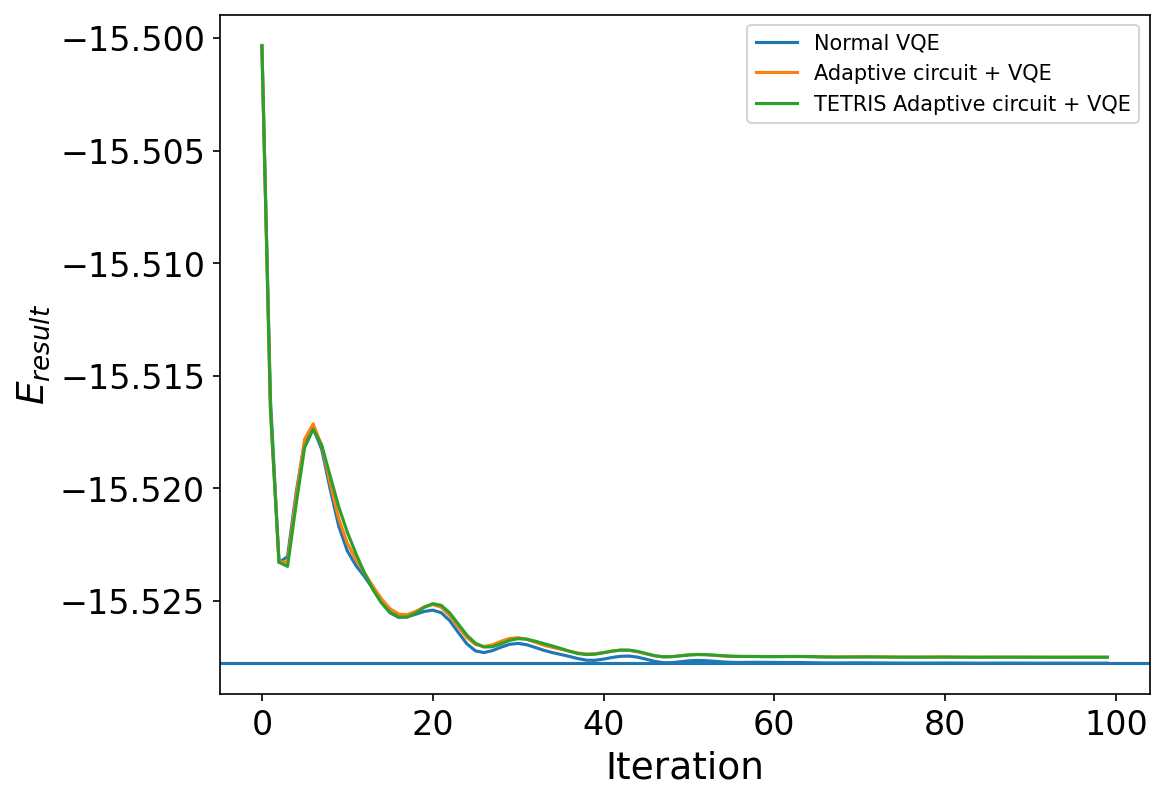

In [127]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(iter, cost_val, label='Normal VQE')
plt.plot(iter, cost_val_a, label='Adaptive circuit + VQE')
plt.plot(iter, cost_val_t, label='TETRIS Adaptive circuit + VQE')
plt.axhline(real_solution_t)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$E_{result}$', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend()
plt.show()

# Method's Comparison
We show how single qubit excitation and double qubit excitation manifested on quantum computer using the single rotation gates and cnot gates.[1] We can convert the single qubit excitation and double qubit excitation gates on the circuit to the native quantum gates. Thus, we can calculate the each method's circuit depth on the real quantum computer.

[1] https://arxiv.org/abs/2209.10562

In [ ]:

def Doublexcitation(param,wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.CNOT(wires=[wires[2],wires[3]])
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RY(param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[3]])
    qml.RY(param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[2])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RY(param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.CNOT(wires=[wires[0],wires[3]])
    qml.RY(param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(-param/8,wires=[wires[0]])
    qml.Hadamard(wires=wires[1])
    qml.RZ(-np.pi/2,wires=[wires[2]])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.RZ(np.pi/2,wires=[wires[0]])
    qml.RZ(-np.pi/2,wires=[wires[2]])
    qml.PauliX(wires=wires[1])
    qml.RY(-np.pi/2,wires=[wires[2]])
    qml.PauliX(wires=wires[3])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.CNOT(wires=[wires[2],wires[3]])

def SingleExcitation(param,wires):
    qml.RZ(np.pi/2,wires=[wires[0]])
    qml.RX(np.pi/2,wires=[wires[0]])
    qml.RX(np.pi/2,wires=[wires[1]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RX(param,wires=[wires[0]])
    qml.RZ(param,wires=[wires[1]])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RX(-np.pi/2,wires=[wires[0]])
    qml.RX(-np.pi/2,wires=[wires[1]])
    qml.RZ(-np.pi/2,wires=[wires[0]])

In [ ]:
a0=0.529177210903
coordinates=[ 0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0] # in atomic unit
charge=0
hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge)

electrons = num_electrons(charge)
num_qubits = len(hamiltonian.wires)

hf_state = hf(electrons, num_qubits)
# singles and doubles are used to make the AllSinglesDoubles template
singles, doubles = qml.qchem.excitations(electrons, num_qubits)

dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit_1(params, excitations):
    #qml.BasisState(hf_state, wires=range(num_qubits))
    for i in range(4):
        qml.PauliX(wires=i)

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            #qml.DoubleExcitation(params[i], wires=excitation)
            Doublexcitation(params[i],excitation)
        else:
            SingleExcitation(params[i],excitation)
            #qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(hamiltonian )


def circuit_2(params, excitations):
    qml.BasisState(hf_state, wires=range(num_qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
            #Doublexcitation(params[i],excitation)
        else:
            #SingleExcitation(params[i],excitation)
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(hamiltonian )

specs_func = qml.specs(circuit_1)
print("Orginal VQE circuit's depth:",specs_func(best_weights, doubles+singles)['depth'])

params = [0.0] * len(doubles)
params=np.array(params )

dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads_d = circuit_gradient(params, excitations=doubles)


params = [0.0] * len(singles)
params=np.array(params )
dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads_s = circuit_gradient(params, excitations=singles)


doubles_select = [(doubles*2)[i] for i in range(len(doubles)) if abs(grads_d[i]) > 1e-5]
singles_select = [(singles*2)[i] for i in range(len(singles)) if abs(grads_s[i]) > 1e-5]
dev = qml.device("default.qubit", wires=num_qubits)

specs_func = qml.specs(circuit_1)
print("Adaptive circuit's depth:",specs_func(best_weights_a, doubles_select+singles_select)['depth'])
      
params = [0.0] * len(doubles+singles)
params=np.array(params )

dev = qml.device("default.qubit", wires=num_qubits)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads = circuit_gradient(params, excitations=doubles+singles)

op_pool=doubles+singles
new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
          

Stacked_op_pool=[]

indx=np.argsort(np.abs(new_grads))
sorted_op_pool=[new_op_pool[idx] for idx in indx]

Stacked_op_pool=[]
q_layer=[]     
ind_left=[]       
while len(sorted_op_pool) !=0:
    for idx, op in enumerate(sorted_op_pool):
        if Stacked_op_pool==[]:
            Stacked_op_pool.append(op)
            q_layer=q_layer+op
        else:
            Stack=True
            for k in op:
                if k in q_layer:
                    Stack=False
                    ind_left.append(idx)
                    break
            if Stack:
                Stacked_op_pool.append(op)
                q_layer=q_layer+op
    sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]
    q_layer=[]
    ind_left=[]
dev = qml.device("default.qubit", wires=num_qubits)
specs_func = qml.specs(circuit_1)
print("TETRIS Adaptive circuit's depth:",specs_func(best_weights_a, Stacked_op_pool)['depth'])

Orginal VQE circuit's depth: 1535
Adaptive circuit's depth: 266
TETRIS Adaptive circuit's depth: 147


# Adaptive VQE + adaptive circuit

Here, we reproduce paper[1]'s work. Every each iteration, we add the largest grafient gate to the circuits, and set up the new parameter of the gate zero. Here, we use adaptive circuit to set up the initial trial state, and train the circuit with adaptive VQE. 

[1] https://www.nature.com/articles/s41467-019-10988-2 

In [57]:
def adapt_vqe_run(r,sol=-15.527759639229922,active_orb=6, num_e=4):
    a0=0.529177210903 #bohr to angstrom
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0,0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge, active_orb=active_orb, num_e=num_e)# step.1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) 
    pool_operators=singles+doubles

    num_qubits = len(hamiltonian.wires)
    hf_state = hf(electrons, num_qubits)
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian)

    params = [0.0] * len(doubles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] # remove the gate with samller gradient


    epochs=25
    conv_tol=1e-5
    energy=[]

    operator_circuits=doubles_select+singles_select
    params = [0.0] * len(operator_circuits)
    params=np.array(params )

    opt = qml.GradientDescentOptimizer(stepsize=0.5) 

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0)#step.2

    energy = [cost_fn(params, operator_circuits)] # step.2
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):
          
        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)

        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]
        maxpos = np.argmax(np.abs(test_grads))
        
        max_op=pool_operators[maxpos]   # step.4 for adaptive one
        operator_circuits.append(max_op)# step.4 
        params=np.append(params, 0.0)   # step.4
        
        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) # Step 3. 
        #t2 = time.time()
        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break

    return n+1, energy, params, operator_circuits

In [69]:
r=1.7
iteration_needed_aa, energy_aa, params_aa, operator_circuits_aa=adapt_vqe_run(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 14

Epoch = 1, Energy = -15.49742667 Ha
Number of gates = 15

Circuit Depth = 15

Epoch = 2, Energy = -15.51269841 Ha
Number of gates = 16

Circuit Depth = 16

Epoch = 3, Energy = -15.52057484 Ha
Number of gates = 17

Circuit Depth = 16

Epoch = 4, Energy = -15.52440330 Ha
Number of gates = 18

Circuit Depth = 17

Epoch = 5, Energy = -15.52609793 Ha
Number of gates = 19

Circuit Depth = 18

Epoch = 6, Energy = -15.52687692 Ha
Number of gates = 20

Circuit Depth = 18

Epoch = 7, Energy = -15.52720951 Ha
Number of gates = 21

Circuit Depth = 19

Epoch = 8, Energy = -15.52735670 Ha
Number of gates = 22

Circuit Depth = 19

Epoch = 9, Energy = -15.52743774 Ha
Number of gates = 23

Circuit Depth = 20

Epoch = 10, Energy = -15.52750378 Ha
Number of gates = 24

Circuit Depth = 20

Epoch = 11, Energy = -15.52756492 Ha
Number of gates = 25

Circuit Depth = 21

Epoch = 12, Energy = -15.52761644 Ha
Number of gates = 26

Ci

# Adaptive VQE + TETRIS adaptive circuit

The step on the comment is assoicated with the paper [1].

[1] https://arxiv.org/abs/2209.10562



In [63]:
def adapt_vqe_run2(r,sol=-15.527759639229922,active_orb=6,num_e=4):
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge,active_orb=active_orb, num_e=num_e) #step.1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) #generate UCCSD operators
    pool_operators=singles+doubles

    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )



    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] #    


    # create the ansatz with large gradient gates, and stack them well.
    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    operator_circuits=[]     
    while len(sorted_op_pool) !=0:
        q_layer=[]     
        ind_left=[]  
        for idx, op in enumerate(sorted_op_pool):
            if operator_circuits==[]:
                operator_circuits.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    operator_circuits.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]

    params = [0.0] * len(doubles_select+singles_select)
    params=np.array(params )

    q_layer=[]
    epochs=25
    conv_tol=1e-5
    energy=[]

    opt = qml.GradientDescentOptimizer(stepsize=0.3) 
    dev = qml.device("default.qubit", wires=num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0) #step.2

    energy = [cost_fn(params, operator_circuits)]  #step.2
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):

        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)
        
        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]

        test_sorted_indx=np.argsort(np.abs(test_grads))[::-1]

        operator_circuits.append(pool_operators[test_sorted_indx[0]]) #step.4 for adaptive one
        params=np.append(params, 0.0)                                 #step.4

        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) # Step 3. ##-15.594361071247999 6 orbital #-15.56723276 4 orbital
        #t2 = time.time()
        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break
    return n+1, energy, params, operator_circuits

In [75]:
iteration_needed_at, energy_at, params_at, operator_circuits_at=adapt_vqe_run2(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 8

Epoch = 1, Energy = -15.49742131 Ha
Number of gates = 15

Circuit Depth = 9

Epoch = 2, Energy = -15.51267349 Ha
Number of gates = 16

Circuit Depth = 10

Epoch = 3, Energy = -15.52054134 Ha
Number of gates = 17

Circuit Depth = 10

Epoch = 4, Energy = -15.52437679 Ha
Number of gates = 18

Circuit Depth = 11

Epoch = 5, Energy = -15.52608151 Ha
Number of gates = 19

Circuit Depth = 12

Epoch = 6, Energy = -15.52686867 Ha
Number of gates = 20

Circuit Depth = 12

Epoch = 7, Energy = -15.52720787 Ha
Number of gates = 21

Circuit Depth = 13

Epoch = 8, Energy = -15.52735709 Ha
Number of gates = 22

Circuit Depth = 13

Epoch = 9, Energy = -15.52743873 Ha
Number of gates = 23

Circuit Depth = 14

Epoch = 10, Energy = -15.52750492 Ha
Number of gates = 24

Circuit Depth = 14

Epoch = 11, Energy = -15.52756601 Ha
Number of gates = 25

Circuit Depth = 15

Epoch = 12, Energy = -15.52761739 Ha
Number of gates = 26

Circ

# TETRIS Adaptive VQE + TETRIS adaptive circuit

The step on the comment is assoicated with the paper [1].

[1] https://arxiv.org/abs/2209.10562

In [73]:
def TETRIS_adapt_vqe_run(r,cutoff=0.0,paper_ver=True,sol=-15.527759639229922,active_orb=6,num_e=4):
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates),charge,active_orb=active_orb, num_e=num_e) # step 1

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)

    singles, doubles = qml.qchem.excitations(electrons, num_qubits) #generate single qubit excitations and double qubit excitations operators.
    pool_operators=singles+doubles

    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(num_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(hamiltonian )


    # create the ansatz with large gradient gates, and stack them well.
    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    op_pool=doubles+singles
    new_op_pool=[op_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_d = circuit_gradient(params, excitations=doubles)

    params = [0.0] * len(singles)
    params=np.array(params )

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads_s = circuit_gradient(params, excitations=singles)

    threshold=1e-5
    doubles_select = [(doubles)[i] for i in range(len(doubles)) if abs(grads_d[i]) > threshold] # remove the gate with samller gradient
    singles_select = [(singles)[i] for i in range(len(singles)) if abs(grads_s[i]) > threshold] #    

    indx=np.argsort(np.abs(new_grads))
    sorted_op_pool=[new_op_pool[idx] for idx in indx]

    operator_circuits=[]   # the stacked operator which has shallower circuit depth than the adaptive circuit.  
    while len(sorted_op_pool) !=0:
        q_layer=[]     
        ind_left=[]  
        for idx, op in enumerate(sorted_op_pool):
            if operator_circuits==[]:
                operator_circuits.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    operator_circuits.append(op)
                    q_layer=q_layer+op
        sorted_op_pool=[sorted_op_pool[idx] for idx in ind_left]

    params = [0.0] * len(doubles_select+singles_select)
    params=np.array(params )

    q_layer=[]
    epochs=25
    conv_tol=1e-5
    energy=[]

    opt = qml.GradientDescentOptimizer(stepsize=0.2) 
    dev = qml.device("default.qubit", wires=num_qubits)

    dev = qml.device("default.qubit", wires=num_qubits)
    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0) # step 2.

    energy = [cost_fn(params, operator_circuits)] # step 2.
    print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(operator_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))

    for n in range(epochs):

        Test_set=operator_circuits+pool_operators
        Test_params=list(params)+[0.0]*len(pool_operators)
        Test_params=np.array(Test_params)
        
        test_grads = circuit_gradient(Test_params,Test_set)
        test_grads = test_grads[len(params):]

        test_sorted_indx=np.argsort(np.abs(test_grads))[::-1] # step 4.(a)
        maxpos=test_sorted_indx[0]
        Larger_sorted_indx=[]
        for ind in test_sorted_indx:
            if np.abs(test_grads[ind]) < np.abs(test_grads[maxpos])*cutoff:
                break
            else:
                Larger_sorted_indx.append(ind)

        for k,ind in enumerate(Larger_sorted_indx): # Step 4 (b)(c)(d)(e)
            #if k != 0:
            #    break
            op_set=set(pool_operators[ind])
            q_layer_set=set(q_layer)
            if not bool(op_set & q_layer_set):
                q_layer=q_layer+pool_operators[ind]
                operator_circuits.append(pool_operators[ind])
                params=np.append(params, 0.0)
            if (len(q_layer)>=num_qubits-4) and paper_ver: # It is hard to find the operators with non-zero gradient fill all qubit layers.
                q_layer=[]                                 # We leave at maximum 4 idle qubits
                break

        if not  paper_ver: # Since fill the qubit layers is hard, we also try to update q_layer each iteration if one don't want to use paper's step.4 (c)(d)
            q_layer=[]

        params,_ = opt.step(cost_fn, params, operator_circuits) # Step 5.
        E_val=cost_fn(params, operator_circuits)
        energy.append(E_val)
        conv = np.abs(sol - E_val) #step 3.

        print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha")
        print("Number of gates = {}\n".format(len(operator_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=operator_circuits)
        print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break
    return n+1, energy, params, operator_circuits

In [98]:
iteration_needed_tt, energy_tt, params_tt, operator_circuits_tt=TETRIS_adapt_vqe_run(r)

Epoch = 0,  Energy = -15.47060578 Ha
Number of gates = 14

Circuit Depth = 8

Epoch = 1, Energy = -15.49828954 Ha
Number of gates = 16

Circuit Depth = 9

Epoch = 2, Energy = -15.51475620 Ha
Number of gates = 18

Circuit Depth = 10

Epoch = 3, Energy = -15.52242107 Ha
Number of gates = 20

Circuit Depth = 11

Epoch = 4, Energy = -15.52565156 Ha
Number of gates = 22

Circuit Depth = 12

Epoch = 5, Energy = -15.52677924 Ha
Number of gates = 24

Circuit Depth = 13

Epoch = 6, Energy = -15.52719755 Ha
Number of gates = 26

Circuit Depth = 14

Epoch = 7, Energy = -15.52736752 Ha
Number of gates = 28

Circuit Depth = 15

Epoch = 8, Energy = -15.52747918 Ha
Number of gates = 32

Circuit Depth = 16

Epoch = 9, Energy = -15.52758265 Ha
Number of gates = 36

Circuit Depth = 17

Epoch = 10, Energy = -15.52766213 Ha
Number of gates = 39

Circuit Depth = 18

Epoch = 11, Energy = -15.52771247 Ha
Number of gates = 42

Circuit Depth = 19

Epoch = 12, Energy = -15.52773842 Ha
Number of gates = 45

Circ

In [69]:
def run_VQE_again(r,conv_tol=1e-04,active_orb=6,num_e=4):
    """Performs a VQE routine for the given hydrogen molecule.

    Args:
        coordinates (list(float)): Cartesian coordinates of each hydrogen molecule.
        charge (int): The electric charge given to the hydrogen molecule.:

    Returns:
        (float): The expectation value of the hydrogen Hamiltonian.
    """
    a0=0.529177210903
    coordinates=[0.0, 0.0, -r/a0, 0.0, 0.0, 0.0, 0.0, 0.0, r/a0]
    charge=0
    hamiltonian = hydrogen_hamiltonian(np.array(coordinates), charge, active_orb=active_orb)

    electrons = num_e
    num_qubits = len(hamiltonian.wires)

    hf_state = hf(electrons, num_qubits)
    # singles and doubles are used to make the AllSinglesDoubles template
    singles, doubles = qml.qchem.excitations(electrons, num_qubits)
    #print("Hamiltonian Length:", len(singles)+len(doubles))
    #print(num_qubits,len(singles))

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost(weights):
        """A circuit with tunable parameters/weights that measures the expectation value of the hydrogen Hamiltonian.
        
        Args:
            weights (numpy.array): An array of tunable parameters.

        Returns:
            (float): The expectation value of the hydrogen Hamiltonian.
            
        """
        #state=np.array([0]*(num_qubits//2)+[1]*(num_qubits//2))
        qml.BasisState(hf_state, wires=list(range(num_qubits)))
        
        for i in range(len(singles)):
            #for j in range(E_len):
            qml.SingleExcitation(weights[i], wires=singles[i])

        for i in range(len(doubles)):
            qml.DoubleExcitation(weights[i+len(singles)], wires=doubles[i])
        
        return qml.expval(hamiltonian)
    
    weights =np.zeros(len(singles) + len(doubles), requires_grad=True)
    opt = qml.AdamOptimizer(0.5)

    iter=[]
    cost_val=[]
    for i in range(100):
        weights = opt.step(cost, weights)
        iter.append(i)
        e=cost(weights)
        conv = np.abs(np.real(real_solution_t) - e)

        configs=qml.specs(cost)(weights)
        print(i, e)
        cost_val.append(e)
        if conv <= conv_tol:
            break


    return i+1, cost_val, weights, singles+doubles

In [79]:
iteration_needed, energy, params, operator_circuits=run_VQE_again(r,conv_tol=1e-05)

0 -15.053129346794641
1 -15.371235289451096
2 -15.460717891550635
3 -15.302615484105411
4 -15.350726026839395
5 -15.47079165170936
6 -15.48074349415397
7 -15.42829393972106
8 -15.416458304878889
9 -15.460085692642597
10 -15.500164788369233
11 -15.489725194489717
12 -15.466180355801125
13 -15.47102002543177
14 -15.496952694433746
15 -15.509529452027754
16 -15.498686681417444
17 -15.489433790312306
18 -15.497418977002525
19 -15.511624891569383
20 -15.515814815915267
21 -15.50945437861538
22 -15.504632366976878
23 -15.509213251746253
24 -15.518270166475535
25 -15.521336864586448
26 -15.516336556736164
27 -15.512365989018026
28 -15.516592961982992
29 -15.523506874916828
30 -15.523722015413046
31 -15.519182093715479
32 -15.518394890169649
33 -15.522479643822871
34 -15.525289815388577
35 -15.523791962181342
36 -15.52200503261476
37 -15.523333518225707
38 -15.525377128800972
39 -15.525270671518879
40 -15.524339015008444
41 -15.524902419632184
42 -15.526013791984113
43 -15.525807760775228
44 -

# Comparison

In [76]:
num_qubits=12
print("In order to get result with error within 1e-5")
print("Adaptive vqe + adaptive circuit needs ",iteration_needed_aa, " iterations")
print("Adaptive vqe + TETRIS adaptive circuit needs ",iteration_needed_at, " iterations")
print("TETRIS adaptive vqe + TETRIS adaptive circuit needs ",iteration_needed_tt, " iterations")
print("Orginal vqe needs ", iteration_needed, "iterations")

dev = qml.device("default.qubit", wires=num_qubits)
specs_func = qml.specs(circuit_1)
print(" ")
print("Adaptive vqe + adaptive circuit depth:",specs_func(params_aa, operator_circuits_aa)['depth'])
print("Adaptive vqe + TETRIS adaptive circuit depth:",specs_func(params_at, operator_circuits_at)['depth'])
print("TETRIS adaptive vqe + TETRIS adaptive circuit depth:",specs_func(params_tt, operator_circuits_tt)['depth'])
print("VQE circuit depth:",specs_func(params, operator_circuits)['depth'])



In order to get result with error within 1e-5
Adaptive vqe + adaptive circuit needs  19  iterations
Adaptive vqe + TETRIS adaptive circuit needs  19  iterations
TETRIS adaptive vqe + TETRIS adaptive circuit needs  13  iterations
Orginal vqe needs  91 iterations
 
Adaptive vqe + adaptive circuit depth: 431
Adaptive vqe + TETRIS adaptive circuit depth: 313
TETRIS adaptive vqe + TETRIS adaptive circuit depth: 389
VQE circuit depth: 1536


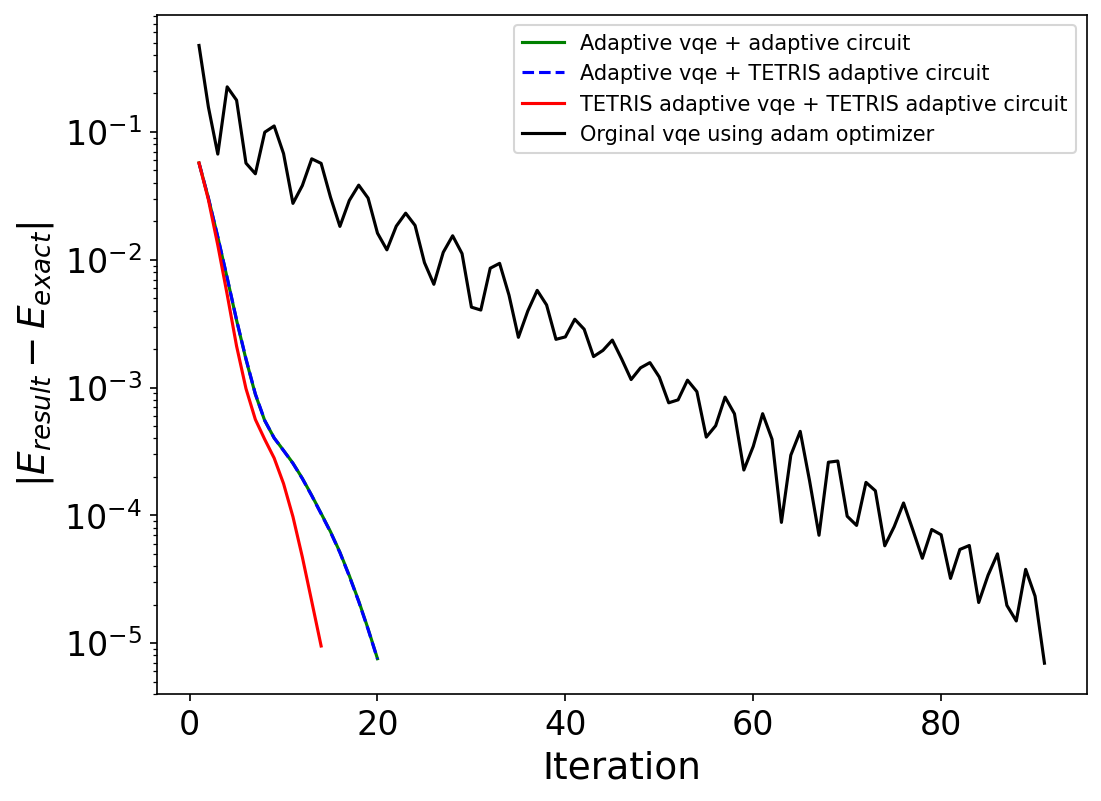

In [77]:
plt.figure(figsize=(8, 6), dpi=150)
iteration_needed_tt_lst=[i+1 for i in range(iteration_needed_tt+1)]
iteration_needed_at_lst=[i+1 for i in range(iteration_needed_at+1)]
iteration_needed_aa_lst=[i+1 for i in range(iteration_needed_aa+1)]
iteration_needed_lst=[i+1 for i in range(iteration_needed)]
plt.plot(iteration_needed_aa_lst, np.array(energy_aa)-real_solution_t, 'g-', label='Adaptive vqe + adaptive circuit')
plt.plot(iteration_needed_at_lst, np.array(energy_at)-real_solution_t, 'b--', label='Adaptive vqe + TETRIS adaptive circuit')
plt.plot(iteration_needed_tt_lst, np.array(energy_tt)-real_solution_t, 'r', label='TETRIS adaptive vqe + TETRIS adaptive circuit')
plt.plot(iteration_needed_lst, np.array(energy)-real_solution_t, 'k', label='Orginal vqe using adam optimizer')
plt.yscale('log')
plt.ylabel('$|E_{result}-E_{exact}|$', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

# The bond length vs ground state energy
(12 qubits require amount of time for qiskit to get exact solution)

In [47]:
from qiskit.algorithms import NumPyMinimumEigensolver
def get_sol_from_qiskit(r,active_orb=6,num_electrons=4,parity=False):
    hydrogen_t = [["H", [-r, 0.0, 0.0]], 
                  ["Be", [0.0, 0.0, 0.0]], 
                  ["H", [r, 0.0, 0.0]]]
                      
    h3p = Molecule(
        geometry=  hydrogen_t,
        multiplicity=1, 
        charge=0, 
    )

    driver = ElectronicStructureMoleculeDriver(h3p, basis="sto-3g", driver_type=ElectronicStructureDriverType.PYSCF) 

    properties = driver.run()
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space around the Fermi level 
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=num_electrons, #how many electrons we have in our active space
        num_molecular_orbitals=active_orb, #how many orbitals we have in our active space
    )

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()
    if parity !=True:
        mapper = JordanWignerMapper()

        converter = QubitConverter(mapper)

        qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])

    else:
        parity_mapper = ParityMapper()
        # Set the qubit converter with two qubit reduction to reduce the computational cost 
        parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)    

        # Compute the Hamitonian in qubit form
        qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

    
    vqe_factory = VQEUCCFactory( # This is an example of UCC"SD" ansatz
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
    ) 

    numpy_solver = NumPyMinimumEigensolver()
    if parity==True:
        solver = GroundStateEigensolver(parity_converter, vqe_factory)  
        real_solution_t = solver.solve(problem_reduced).total_energies[0]
    else:
        solver = GroundStateEigensolver(converter, vqe_factory)  
        real_solution_t = solver.solve(problem_reduced).total_energies[0]
    return  real_solution_t

In [ ]:
r_lst=[i*0.2+0.8 for i in range(9)]
TT_result=[]
for r_s in r_lst:  
    _, energy_tt, _, _=TETRIS_adapt_vqe_run(r_s,cutoff=0.9,paper_ver=False)
    TT_result.append(energy_tt[-1])

In [ ]:
AA_result=[]
for r_s in r_lst:
    _, energy_aa, _, _=adapt_vqe_run(r_s)
    AA_result.append(energy_aa[-1])

In [ ]:
AT_result=[]
for r_s in r_lst:
    _, energy_at, _, _=adapt_vqe_run2(r_s)
    AT_result.append(energy_at[-1])

In [ ]:
exact=[]
result=[]
for r_s in r_lst:
    exact.append(get_sol_from_qiskit(r_s))
    _, energy, _, _=run_VQE_again(r_s)
    result.append(energy[-1])


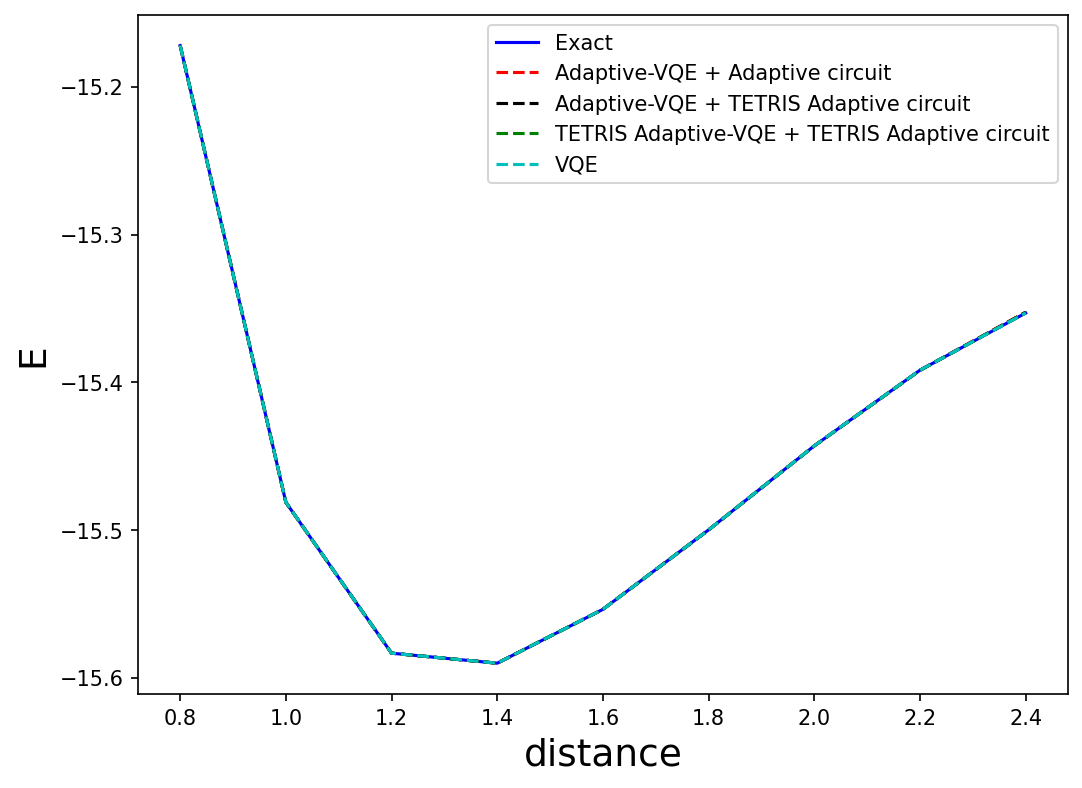

In [128]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(r_lst,exact,'b', label='Exact')
plt.plot(r_lst,AA_result,'r--', label='Adaptive-VQE + Adaptive circuit')
plt.plot(r_lst,AT_result,'k--', label='Adaptive-VQE + TETRIS Adaptive circuit')
plt.plot(r_lst,TT_result,'g--', label='TETRIS Adaptive-VQE + TETRIS Adaptive circuit')
plt.plot(r_lst,result,'c--', label='VQE')
plt.legend()
plt.ylabel('E', fontsize=18)
plt.xlabel('distance', fontsize=18)
plt.show()

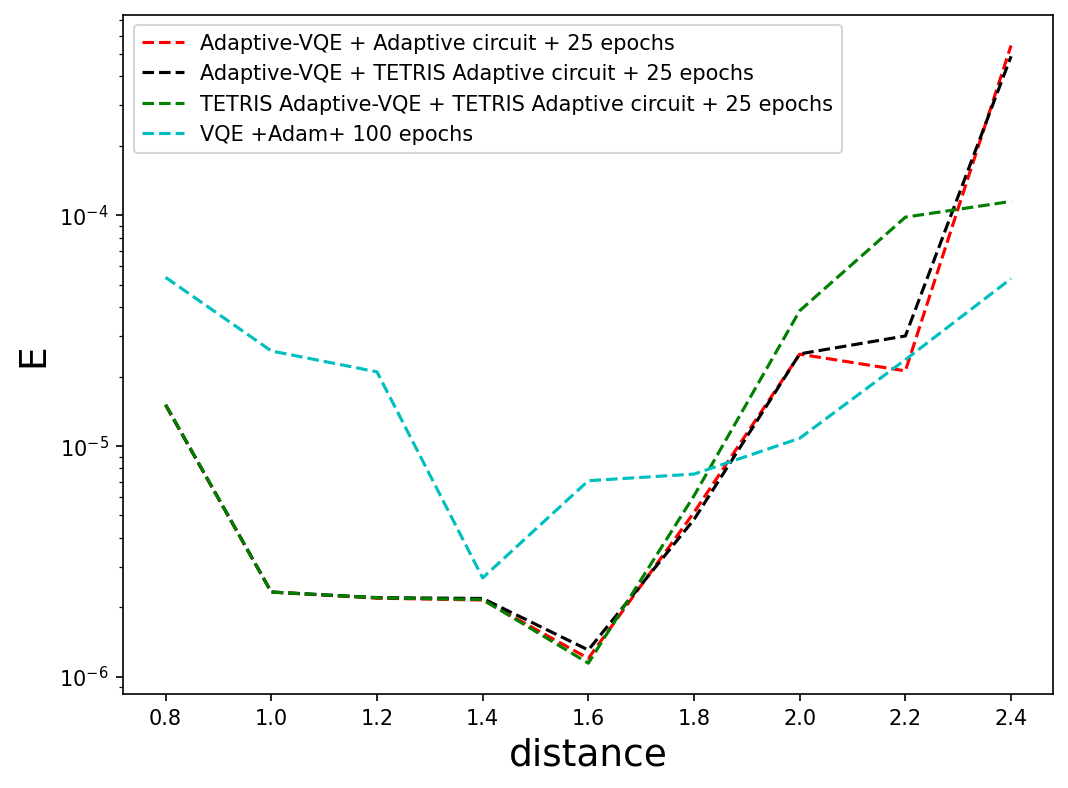

In [120]:
#plt.plot(r_lst,exact,'b', label='Exact')
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(r_lst,np.abs(np.array(exact)-np.array(AA_result)),'r--', label='Adaptive-VQE + Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(AT_result)),'k--', label='Adaptive-VQE + TETRIS Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(TT_result)),'g--', label='TETRIS Adaptive-VQE + TETRIS Adaptive circuit + 25 epochs')
plt.plot(r_lst,np.abs(np.array(exact)-np.array(result)),'c--', label='VQE +Adam+ 100 epochs')
plt.legend()
plt.yscale('log')
plt.ylabel('E', fontsize=18)
plt.xlabel('distance', fontsize=18)
plt.show()

When bond length is between 0.8 and 1.8 angstrom, with only 25 iterations, both of ADAPT vqe and TETRIS-ADAPT vqe work well and reach the result with error within 1e-5.However, when bond length is larger than 1.8 angstrom. The accuracy of the result from ADAPT vqe and TETRIS-ADAPT vqe becomes worse. There are two solution could make result better. The stepsize of optimizer could be tuned larger. One could also run more iteration and see whether the result is improve or not.